<a href="https://colab.research.google.com/github/RajBharti25/Credit-Card-Lead-Prediction/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [64]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
from sklearn import preprocessing
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import pydot

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import fmin, tpe

%matplotlib inline
plt.style.use('ggplot')

In [91]:
train_dir='/content/drive/MyDrive/Colab Notebooks/Jobathon/data/train_data.csv'
test_dir='/content/drive/MyDrive/Colab Notebooks/Jobathon/data/test_data.csv'
dir='/content/drive/MyDrive/Colab Notebooks/Jobathon/data/'
df=pd.read_csv(train_dir)
print(df.columns)
df.head(7)

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
5,ACUTYTWS,Male,56,RG261,Self_Employed,X1,32,No,544163,Yes,0
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1


In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [6]:
df.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [124]:
df=pd.read_csv(train_dir)
train_id=df['ID']
df.drop(columns=['ID'],inplace=True)
df['Credit_Product']=df['Credit_Product'].astype(str)
le = preprocessing.LabelEncoder()
# df['Age']=MinMaxScaler().fit_transform(np.array(df['Age']).reshape(-1,1))
df['Gender']=le.fit_transform(df['Gender'])
df['Region_Code']=le.fit_transform(df['Region_Code'])
df['Region_Code']=(df['Region_Code']/5).astype(int)
df['Occupation']=le.fit_transform(df['Occupation'])
df['Channel_Code']=le.fit_transform(df['Channel_Code'])
# df['Vintage']=le.fit_transform(df['Vintage'])
df['Credit_Product']=le.fit_transform(df['Credit_Product'])
df['Is_Active']=le.fit_transform(df['Is_Active'])
# df['Avg_Account_Balance']=MinMaxScaler().fit_transform(np.array(df['Avg_Account_Balance']).reshape(-1,1))
df['Avg_Account_Balance']=np.log(df['Avg_Account_Balance'])


In [125]:
X=df.iloc[:,0:9]
y=df.iloc[:,9]
print(X.shape, y.shape)
X.head(), y.head()

(245725, 9) (245725,)


(   Gender  Age  Region_Code  ...  Credit_Product  Avg_Account_Balance  Is_Active
 0       0   73            3  ...               0            13.860193          0
 1       0   30            5  ...               0            13.274205          0
 2       0   56            3  ...               0            14.210464          1
 3       1   34            4  ...               0            13.061453          0
 4       0   30            6  ...               0            13.695360          0
 
 [5 rows x 9 columns], 0    0
 1    0
 2    0
 3    0
 4    0
 Name: Is_Lead, dtype: int64)

In [126]:
X.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,73,3,1,2,43,0,13.860193,0
1,0,30,5,2,0,32,0,13.274205,0
2,0,56,3,3,2,26,0,14.210464,1
3,1,34,4,2,0,19,0,13.061453,0
4,0,30,6,2,0,33,0,13.695360,0


In [127]:
cat_cols=['Occupation','Channel_Code','Region_Code']

In [128]:
X=pd.get_dummies(X, columns=cat_cols)
print(X.shape)
X.head

(245725, 21)


<bound method NDFrame.head of         Gender  Age  Vintage  ...  Region_Code_4  Region_Code_5  Region_Code_6
0            0   73       43  ...              0              0              0
1            0   30       32  ...              0              1              0
2            0   56       26  ...              0              0              0
3            1   34       19  ...              1              0              0
4            0   30       33  ...              0              0              1
...        ...  ...      ...  ...            ...            ...            ...
245720       1   51      109  ...              0              0              1
245721       1   27       15  ...              0              0              0
245722       0   26       13  ...              0              0              1
245723       0   28       31  ...              1              0              0
245724       1   29       21  ...              0              0              0

[245725 rows x 21 col

In [129]:
X.iloc[:5,10:23]

,Channel_Code_0,Channel_Code_1,Channel_Code_2,Channel_Code_3,Region_Code_0,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6
0,0,0,1,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,1


In [130]:
# Define all features
orig_feats = [col for col in df.columns if 'class' not in col]

len(orig_feats)

10

In [76]:
X.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')

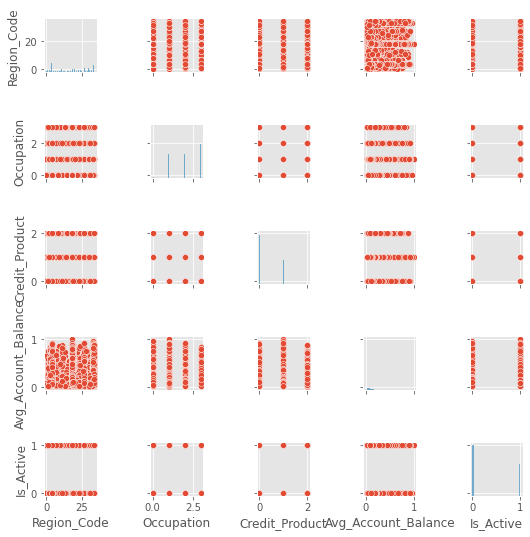

In [79]:
g=sns.pairplot(X,vars=[ 'Region_Code', 'Occupation',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],height=1.5)

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64


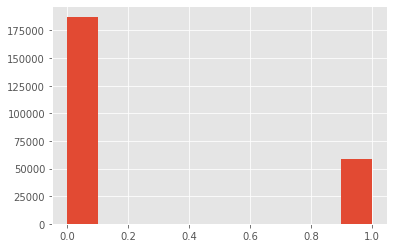

In [84]:
target="Is_Lead"
print(y.value_counts(normalize=True))
y.hist()

In [86]:
df_corr = df.corr()
df_corr.style.background_gradient().set_precision(2)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
Gender,1.00,0.15,0.00,0.03,0.15,0.15,0.08,0.02,0.06,0.07
Age,0.15,1.00,0.12,-0.13,0.61,0.63,0.26,0.15,0.22,0.23
Region_Code,0.00,0.12,1.00,0.01,0.10,0.12,0.08,0.08,0.06,0.06
Occupation,0.03,-0.13,0.01,1.00,0.12,0.03,0.02,-0.04,0.08,0.01
Channel_Code,0.15,0.61,0.10,0.12,1.00,0.54,0.31,0.10,0.25,0.26
Vintage,0.15,0.63,0.12,0.03,0.54,1.00,0.27,0.17,0.21,0.28
Credit_Product,0.08,0.26,0.08,0.02,0.31,0.27,1.00,0.07,-0.01,0.57
Avg_Account_Balance,0.02,0.15,0.08,-0.04,0.10,0.17,0.07,1.00,0.08,0.05
Is_Active,0.06,0.22,0.06,0.08,0.25,0.21,-0.01,0.08,1.00,0.09
Is_Lead,0.07,0.23,0.06,0.01,0.26,0.28,0.57,0.05,0.09,1.00


In [87]:
df.corr()['Is_Lead'].sort_values()

Occupation             0.012415
Avg_Account_Balance    0.053370
Region_Code            0.062501
Gender                 0.072068
Is_Active              0.085723
Age                    0.230814
Channel_Code           0.261211
Vintage                0.279337
Credit_Product         0.570449
Is_Lead                1.000000
Name: Is_Lead, dtype: float64

In [ ]:
# X.drop(columns=['Region_Code','Gender','Avg_Account_Balance','Is_Active'],inplace=True)
# X.shape

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=1,test_size=0.001)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(245479, 21) (246, 21) (245479,) (246,)


In [137]:
print(y_train.value_counts(normalize=True),'\n\n')
print(y_test.value_counts(normalize=True))

0    0.76279
1    0.23721
Name: Is_Lead, dtype: float64 


0    0.764228
1    0.235772
Name: Is_Lead, dtype: float64


In [92]:
# predicting all zero
naive_preds = np.zeros(y_test.shape[0])
print(len(naive_preds))
print('roc:',roc_auc_score(y_test, naive_preds))
print("classification report:->\n\n",classification_report(y_test, naive_preds))

61432
roc: 0.5
classification report:->

               precision    recall  f1-score   support

           0       0.76      1.00      0.87     46860
           1       0.00      0.00      0.00     14572

    accuracy                           0.76     61432
   macro avg       0.38      0.50      0.43     61432
weighted avg       0.58      0.76      0.66     61432



In [132]:
num_boost_rounds = 15000
early_stopping_rounds = 30

initial_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [94]:
logit_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, random_state=1))

In [95]:
rf_cv = cross_val_score(estimator=RandomForestClassifier(),
                         X=X_train, 
                         y=y_train,
                         scoring='roc_auc',
                         cv=StratifiedKFold(n_splits=5, random_state=1))

In [ ]:
xgb_cv = cross_val_score(estimator=XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                 early_stopping_rounds=early_stopping_rounds,
                                                 **initial_params),
                          X=X_train,
                          y=y_train,
                          scoring='roc_auc',
                          cv=StratifiedKFold(n_splits=5, random_state=1))

In [97]:
print(f'Logistic Regression CV Mean AUC score: {logit_cv.mean()}')
print(f'Random Forest CV Mean AUC score: {rf_cv.mean()}')
print(f'XGBoost CV Mean AUC score: {xgb_cv.mean()}')

Logistic Regression CV Mean AUC score: 0.8530180844773193
Random Forest CV Mean AUC score: 0.855787057012318
XGBoost CV Mean AUC score: 0.8726306213571817


Text(0.5, 1.0, 'AUC scores using Different Classification Algorithms')

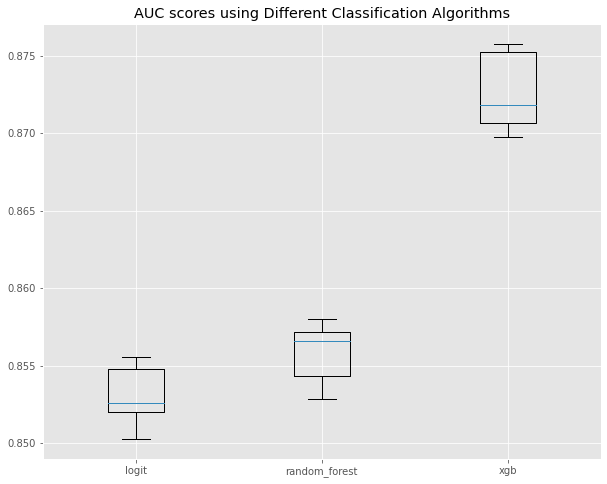

In [98]:
model_cv_results = {'logit': logit_cv, 'random_forest': rf_cv, 'xgb': xgb_cv}

fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(model_cv_results.values())
ax.set_xticklabels(model_cv_results.keys())
plt.title('AUC scores using Different Classification Algorithms')

In [114]:
 oversamp_pipeline = imblearn.pipeline.Pipeline([('oversample', RandomOverSampler(random_state=42)),
                                                ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                      early_stopping_rounds=early_stopping_rounds,
                                                                      **initial_params))])
 
 undersamp_pipeline = imblearn.pipeline.Pipeline([('undersample', RandomUnderSampler(random_state=42)),
                                                 ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                       early_stopping_rounds=early_stopping_rounds,
                                                                       **initial_params))])

smote_pipeline = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=42)),
                                             ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                   early_stopping_rounds=early_stopping_rounds,
                                                                   **initial_params))])

In [115]:
sampling_methods = {'random_oversampling': oversamp_pipeline,
                    'random_undersampling': undersamp_pipeline,
                    'smote': smote_pipeline}

In [108]:
sampling_cv_results = {}

for method, pipeline in sampling_methods.items():
    cv_results = cross_val_score(pipeline, X_train.values, y_train, cv=StratifiedKFold(n_splits=5, random_state=1), scoring='roc_auc')
    sampling_cv_results[method] = cv_results
    print(method, cv_results.mean())

random_oversampling 0.8722675072598667
random_undersampling 0.8720990078204555
smote 0.8673794064678326


Text(0.5, 1.0, 'AUC scores of XGB Classifier using Different Sampling Methods')

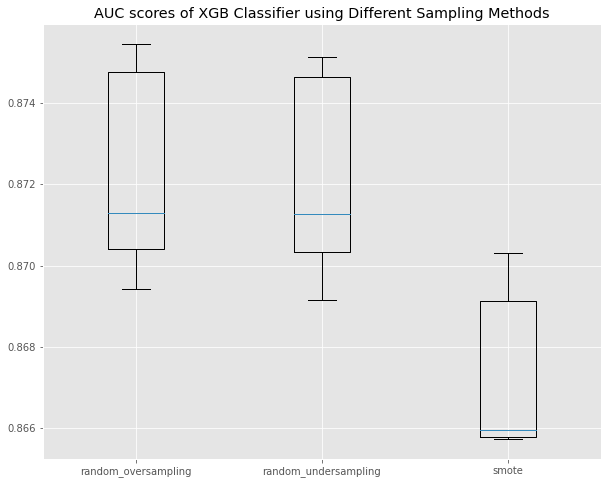

In [109]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(sampling_cv_results.values())
ax.set_xticklabels(sampling_cv_results.keys())
plt.title('AUC scores of XGB Classifier using Different Sampling Methods')

In [110]:
# Set up grid for hyperopt
space = {
    'max_depth': hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'eta': hp.uniform('eta', 0.01, 0.3),
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

In [111]:
# Objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'min_child_weight': int(params['min_child_weight']),
              'gamma': params['gamma'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'objective': params['objective'],
              'eval_metric': params['eval_metric']}
    
    xgb_clf = XGBClassifier(num_boost_rounds=num_boost_rounds, 
                            early_stopping_rounds=early_stopping_rounds,
                            **params)
    
    best_score = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=3).mean()
    
    loss = 1 - best_score 
    
    return loss

In [112]:
best_result = fmin(fn=objective, space=space, max_evals=20, 
                   rstate=np.random.RandomState(42), algo=tpe.suggest)

100%|██████████| 20/20 [14:18<00:00, 42.90s/it, best loss: 0.1261133574748443]


In [113]:
best_params = best_result
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['gamma'] = best_params['gamma']
best_params['colsample_bytree'] = round(best_params['colsample_bytree'], 1)
best_params['eta'] = round(best_params['eta'], 1)
best_params['subsample'] = round(best_params['subsample'], 1)
best_params

{'colsample_bytree': 0.7,
 'eta': 0.2,
 'gamma': 4.5,
 'max_depth': 6,
 'min_child_weight': 16,
 'subsample': 0.7}

###testing phase

In [133]:
best_params={'colsample_bytree': 0.7,
              'eta': 0.2,
              'gamma': 4.5,
              'max_depth': 6,
              'min_child_weight': 16,
              'subsample': 0.7}

In [138]:
final_model = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=1)),
                                          ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds,
                                                                early_stopping_rounds=early_stopping_rounds, 
                                                                **best_params))])

In [139]:
final_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, early_stopping_rounds=30,
                               eta=0.2, gamma=4.5, learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=16, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               num_boost_rounds=15000,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=

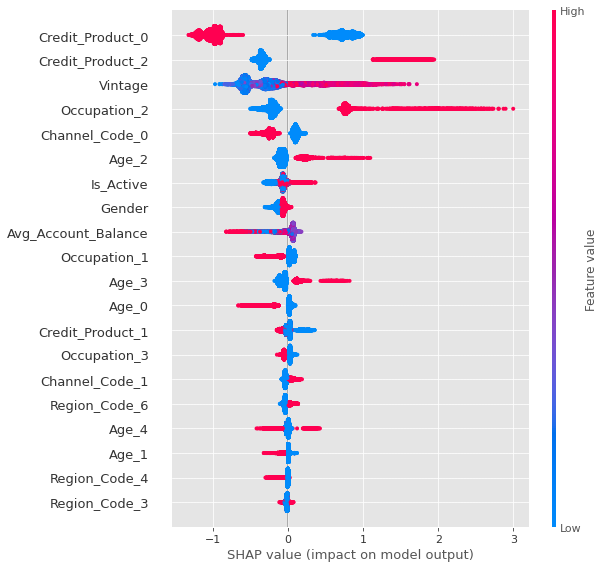

In [61]:
explainer = shap.TreeExplainer(final_model[1])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [140]:
final_preds = final_model.predict_proba(X_test.values)[:,1]

In [141]:
pd.Series(final_preds).describe()

count    246.000000
mean       0.276501
std        0.271088
min        0.027736
25%        0.087598
50%        0.136274
75%        0.365704
max        0.996808
dtype: float64

In [142]:
roc_auc_score(y_test, final_preds)

0.8566581071166545

In [143]:
df=pd.read_csv(test_dir)
test_id=df['ID']
df.drop(columns=['ID'],inplace=True)
df['Credit_Product']=df['Credit_Product'].astype(str)
le = preprocessing.LabelEncoder()
# df['Age']=MinMaxScaler().fit_transform(np.array(df['Age']).reshape(-1,1))
# df['Age']=(df['Age']/10-2).astype(int)
df['Gender']=le.fit_transform(df['Gender'])
df['Region_Code']=le.fit_transform(df['Region_Code'])
df['Region_Code']=(df['Region_Code']/5).astype(int)
df['Occupation']=le.fit_transform(df['Occupation'])
df['Channel_Code']=le.fit_transform(df['Channel_Code'])
df['Vintage']=le.fit_transform(df['Vintage'])
df['Credit_Product']=le.fit_transform(df['Credit_Product'])
df['Is_Active']=le.fit_transform(df['Is_Active'])
# df['Avg_Account_Balance']=MinMaxScaler().fit_transform(np.array(df['Avg_Account_Balance']).reshape(-1,1))
df['Avg_Account_Balance']=np.log(df['Avg_Account_Balance'])
X_eval=df
print(X_eval.shape)

(105312, 9)


In [51]:
X_eval.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,1,0,0,1,0,9,1,13.517598,0
1,1,2,3,1,1,21,2,13.738129,0
2,1,1,4,2,0,4,0,12.282798,0
3,1,0,4,1,0,14,0,13.674028,0
4,0,0,4,1,0,6,0,13.395572,0


In [144]:
# X_eval.drop(columns=['Region_Code','Gender','Avg_Account_Balance','Is_Active'],inplace=True)
# X_eval.shape
X_eval=pd.get_dummies(X_eval, columns=cat_cols)
X_eval.shape

(105312, 21)

In [145]:
result = final_model.predict_proba(X_eval.values)[:,1]

In [146]:
a=final_model.predict(X_eval.values)
a=pd.Series(a)
len(a[a[:]==1])

16645

In [147]:
final_result=pd.DataFrame()
final_result["ID"]=test_id
final_result['Is_Lead']=result
final_result.head()

,ID,Is_Lead
0,VBENBARO,0.068032
1,CCMEWNKY,0.920019
2,VK3KGA9M,0.091186
3,TT8RPZVC,0.038276
4,SHQZEYTZ,0.033389


In [148]:
final_result.to_csv('/content/drive/MyDrive/Colab Notebooks/Jobathon/data/final_result_03.csv', index=False)

In [116]:
a=X_train.copy()

In [93]:
all_data=pd.read_csv(test_dir)
test_id=all_data['ID']

all_data.drop(columns=['ID'],inplace=True)

In [103]:
np.sum(all_data.Credit_Product.isnull()==True)

0

In [101]:
all_data['Credit_Product']=df['Credit_Product'].astype(str)

In [60]:
Index_label = df[df["Occupation"]=="Entrepreneur"].index.tolist()
label=df[df['Credit_Product']=="nan"].index.tolist()
for x in Index_label:
  if x in label:
    df.loc[x,"Credit_Product"]="Yes"

Index_label = df[df["Occupation"]=="Salaried"].index.tolist()
label1=df[df['Age']>=20].index.tolist()
label2=df[df['Age']<40].index.tolist()
label1_s=set(label1)
ll=label1_s.intersection(label2)
label3=df[df['Credit_Product']=="nan"].index.tolist()
for x in Index_label:
  if x in ll and label3:
    df.loc[x,"Credit_Product"]="No"
    
Index_label = df[df["Occupation"]=="Salaried"].index.tolist()
label=df[df['Age']>=40].index.tolist()
for x in Index_label:
  if x in label:
    df.loc[x,"Credit_Product"]="Yes"
Index_label = df[df["Occupation"]=="Self_Employed"].index.tolist()
label=df[df['Credit_Product']=="nan"].index.tolist()
for x in Index_label:
  if x in label:
    df.loc[x,"Credit_Product"]="No"

Index_label = df[df["Occupation"]=="Other"].index.tolist()
label=df[df['Credit_Product']=="nan"].index.tolist()
for x in Index_label:
  if x in label:
    df.loc[x,"Credit_Product"]="No"

In [77]:
a=all_data[all_data['Credit_Product']=="nan"].index.tolist()
len(a)

0

In [102]:
# Condition 1
occ_list_1 = ['Entrepreneur']
all_data.Credit_Product=np.where(all_data.Occupation.isin(occ_list_1),all_data.Credit_Product.fillna('Yes'),all_data.Credit_Product)

# Condition 2

occ_list_2 = ['Salaried']
age_list_2 = np.arange(21,40).tolist()
age_list_3 = np.arange(40,100).tolist()
all_data.Credit_Product=np.where(all_data.Occupation.isin(occ_list_2) & all_data.Age.isin(age_list_2),all_data.Credit_Product.fillna('No'),all_data.Credit_Product)
all_data.Credit_Product=np.where(all_data.Occupation.isin(occ_list_2) & all_data.Age.isin(age_list_3),all_data.Credit_Product.fillna('Yes'),all_data.Credit_Product)
occ_list_3 = ['Self_Employed','Other']
all_data.Credit_Product=np.where(all_data.Occupation.isin(occ_list_3),all_data.Credit_Product.fillna('No'),all_data.Credit_Product)
